# IBM Coursera Capstone Project - The Restaurant Battle of Neighborhoods in Paris

## Introduction

This notebbok describes the Python code that made possible to develop the Capstone Project requested in the last course leading to the IBM Data Science Professional Certicate.

The problem I have chosen to deal with is totally imaginary.

My company, Data Consulting, specializing in data analysis, was contacted by the Paris City Tourist Office to provide them with an analysis that would allow them to advise tourists on the types of restaurants they might find. during their visits to the Parisian districts. .

This analysis could be carried out using an unsupervised learning model which would reproduce on the map of Paris the groupings of neighborhoods according to the types of restaurants that are most represented there.

## Methodology

To conduct this study, I list below the different steps of the methodology that I followed:
- Step 1 : Data Acquisition with the JSON library
- Step 2 : Preparing, Cleaning and Merging Data with the PANDA library
- Step 3 : Venues Acquisiton with the Folium library
- Step 4 : One Hot Encoding with the PANDA library
- Step 5 : Clustering K-means with sklearn.cluster library
- Step 6 : Cluster Analysis
- Step 7 : Creation of a clusters map with the folium library



### Step 00 - Import the needed Library

In [6]:
## import the needed Library
import pandas as pd
#import numpy as np
import urllib
from bs4 import BeautifulSoup
import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
#from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

import geopy
from  geopy.geocoders import Nominatim
nominatim_service = Nominatim(user_agent='X@yy.com') # Important line
geopy.geocoders.options.default_user_agent = "X@yy.com" # Important line
geolocator = Nominatim()

print('package installed')

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python-3.7-main

  added / updated specs:
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    altair-4.1.0               |             py_1         614 KB  conda-forge
    branca-0.4.2               |     pyhd8ed1ab_0          26 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         713 KB

The following NEW packages will be INSTALLED:

  altair             conda-forge/noarch::altair-4.1.0-py_1
  branca             conda-forge/noarch::branca-0.4.2-pyhd8ed1ab_0
  fol

### Step 01 - Data Acquisition with the JSON library

Data,in geojson format, are available on the web site https://opendata.paris.fr/explore/dataset/arrondissements/export/?location=13,48.85156,2.32327.
I saved these files in the same directory as my jupyter notebook.

In [ ]:
borough = "arrondissements.geojson" # Paris arrondissements
geo_borough = json.load(open(borough)) # Paris arrondissements
geo_neighbourhood = json.load(open("quartier_paris.geojson")) # Paris neighborhoods

In [3]:
geo_borough.keys()

dict_keys(['type', 'features'])

In [4]:
geo_borough["type"]

'FeatureCollection'

We are checking that we have the 20 arrondissements of Paris in the features object, which is a list.

In [5]:
len(geo_borough["features"])

20

In each object of this list, we also have different Feature type objects.

In [6]:
geo_borough["features"][0].keys()

dict_keys(['type', 'geometry', 'properties'])

In [7]:
geo_borough["features"][0]['type']

'Feature'

In the properties field, there are various useful information, including the longitude and latitude coordinates of the center.

In [8]:
geo_borough["features"][0]['properties']

{'n_sq_co': 750001537,
 'perimetre': 4519.26364836,
 'l_ar': '3ème Ardt',
 'surface': 1170882.82818778,
 'geom_x_y': [48.86287238, 2.3600009859],
 'n_sq_ar': 750000003,
 'l_aroff': 'Temple',
 'c_arinsee': 75103,
 'c_ar': 3}

In [9]:
geo_neighbourhood["features"][0]['properties']

{'n_sq_qu': 750000015,
 'n_sq_ar': 750000004,
 'geom_x_y': [48.851585175, 2.36476795387],
 'c_qu': 15,
 'surface': 487264.93707154,
 'l_qu': 'Arsenal',
 'perimetre': 2878.55965556,
 'c_quinsee': 7510403,
 'c_ar': 4}

For the rest of the project, with the Panda library imported previously, we have created 2 DataFrames with the useful information.

In [10]:
# Borough Dataframe
bouroughDF = pd.DataFrame({
     "BoroughNumber"    : [bor["properties"]["c_ar"] for bor in geo_borough["features"]]
    ,"Borough"          : [bor["properties"]["l_aroff"] for bor in geo_borough["features"]]
    ,"Latitude"   : [bor["properties"]["geom_x_y"][0] for bor in geo_borough["features"]]
    ,"Longitude" : [bor["properties"]["geom_x_y"][1] for bor in geo_borough["features"]]
    ,"BoroughPerimetre" : [bor["properties"]["perimetre"] for bor in geo_borough["features"]]
})
bouroughDF

,BoroughNumber,Borough,Latitude,Longitude,BoroughPerimetre
0,3,Temple,48.862872,2.360001,4519.263648
1,7,Palais-Bourbon,48.856174,2.312188,8099.424883
2,13,Gobelins,48.828388,2.362272,11546.546526
3,17,Batignolles-Monceau,48.887327,2.306777,10775.579516
4,20,Ménilmontant,48.863461,2.401188,10704.940486
5,10,Entrepôt,48.876130,2.360728,6739.375055
6,12,Reuilly,48.834974,2.421325,24089.666298
7,5,Panthéon,48.844443,2.350715,6239.195396
8,8,Élysée,48.872721,2.312554,7880.533268
9,15,Vaugirard,48.840085,2.292826,13678.798315


In [11]:
bouroughDF.shape

(20, 5)

We actually find the 20 arrondissements of Paris

In [12]:
# Neighbourhood Dataframe
neighbourhoodDF = pd.DataFrame({
    "BoroughNumber"  : [neigh["properties"]["c_ar"] for neigh in geo_neighbourhood["features"]]
    ,"NeighNumber"   : [neigh["properties"]['c_qu'] for neigh in geo_neighbourhood["features"]]
    ,"Neighbourhood" : [neigh["properties"]["l_qu"] for neigh in geo_neighbourhood["features"]]
    ,"NeighLatitude" : [neigh["properties"]["geom_x_y"][0] for neigh in geo_neighbourhood["features"]]
    ,"NeighLongitude": [neigh["properties"]["geom_x_y"][1] for neigh in geo_neighbourhood["features"]]
    ,"NeighGeoloc"   : [neigh["properties"]["geom_x_y"] for neigh in geo_neighbourhood["features"]]
    ,"NeighPerimetre": [neigh["properties"]["perimetre"] for neigh in geo_neighbourhood["features"]]
})
neighbourhoodDF

,BoroughNumber,NeighNumber,Neighbourhood,NeighLatitude,NeighLongitude,NeighGeoloc,NeighPerimetre
0,4,15,Arsenal,48.851585,2.364768,"[48.851585175, 2.36476795387]",2878.559656
1,5,18,Jardin-des-Plantes,48.841940,2.356894,"[48.8419401934, 2.35689388962]",4052.729521
2,10,39,Porte-Saint-Martin,48.871245,2.361504,"[48.8712446509, 2.36150364735]",3245.891413
3,11,43,Roquette,48.857064,2.380364,"[48.8570640408, 2.38036406173]",4973.010557
4,12,46,Picpus,48.830359,2.428827,"[48.8303592424, 2.42882681508]",18261.910318
...,...,...,...,...,...,...,...
75,19,75,Amérique,48.881638,2.395440,"[48.8816381673, 2.39544016662]",6399.022082
76,8,32,Europe,48.878148,2.317175,"[48.8781476759, 2.3171746113]",4803.242769
77,11,44,Sainte-Marguerite,48.852097,2.388765,"[48.852096507, 2.3887648336]",4591.310799
78,14,54,Parc-de-Montsouris,48.823453,2.337070,"[48.8234527716, 2.33707017986]",5224.265369


In [13]:
neighbourhoodDF.shape

(80, 7)

We actually find the 80 neighbourhoods of Paris

### Step 02 - Preparing, Cleaning and Merging Data with the PANDA library

#### Merge boroughDF with neighbourhoodDF => borough_neighbourhoodDF

In [14]:
borough_neighbourhoodDF= bouroughDF.set_index('BoroughNumber').join(neighbourhoodDF.set_index('BoroughNumber')).reset_index()
borough_neighbourhoodDF.head()

,BoroughNumber,Borough,Latitude,Longitude,BoroughPerimetre,NeighNumber,Neighbourhood,NeighLatitude,NeighLongitude,NeighGeoloc,NeighPerimetre
0,1,Louvre,48.862563,2.336443,6054.936862,3,Palais-Royal,48.864660,2.336309,"[48.8646599781, 2.33630891897]",2166.839239
1,1,Louvre,48.862563,2.336443,6054.936862,1,Saint-Germain-l'Auxerrois,48.860650,2.334910,"[48.8606501352, 2.33491032928]",5057.549475
2,1,Louvre,48.862563,2.336443,6054.936862,2,Halles,48.862289,2.344899,"[48.8622891081, 2.34489885831]",2606.417128
3,1,Louvre,48.862563,2.336443,6054.936862,4,Place-Vendôme,48.867019,2.328582,"[48.8670185906, 2.32858166493]",2147.817602
4,2,Bourse,48.868279,2.342803,4554.104360,6,Vivienne,48.869100,2.339461,"[48.8691001998, 2.33946074375]",2058.472959


In [15]:
borough_neighbourhoodDF.shape

(80, 11)

I used this dataframe for the rest of the project. I didn't need to clean the data.

### Step 03 - Venues Acquisiton with the Folium library

#### FourSquare credential and version

In [16]:
@hidden_cell
CLIENT_ID = 'GU0EJCBEB0ACFSSHLIN1LY2QMDXMYC0GRPPYT1VSEMVDFTXM' # your Foursquare ID
CLIENT_SECRET = 'HKGI0ZJHHULNL2IKG0PXH42ILENLMQY3DJUCEDD1DQC1WSAH' # your Foursquare Secret
ACCESS_TOKEN = 'AQBQX232OWVPICDQ1YUWR4J2LZCTZM012NLPYZTTUROY3VP0' # your FourSquare Access Token
VERSION = '20180604'
LIMIT = 30

Your credentails:
CLIENT_ID: GU0EJCBEB0ACFSSHLIN1LY2QMDXMYC0GRPPYT1VSEMVDFTXM
CLIENT_SECRET:HKGI0ZJHHULNL2IKG0PXH42ILENLMQY3DJUCEDD1DQC1WSAH


#### Get Venues (500 meters around the center of the district and 100 venues max for each district)

In [17]:
def getNearbyVenues(names, latitudes, longitudes):
    radius=500
    LIMIT=100
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [18]:
#borough_neighbourhoodDF.shape Neighbourhood	NeighLatitude	NeighLongitude
paris_venues = getNearbyVenues(names=borough_neighbourhoodDF['Neighbourhood'],
                               latitudes=borough_neighbourhoodDF['NeighLatitude'],
                               longitudes=borough_neighbourhoodDF['NeighLongitude']
                                  )

Palais-Royal
Saint-Germain-l'Auxerrois
Halles
Place-Vendôme
Vivienne
Mail
Bonne-Nouvelle
Gaillon
Sainte-Avoie
Arts-et-Métiers
Archives
Enfants-Rouges
Arsenal
Saint-Gervais
Saint-Merri
Notre-Dame
Jardin-des-Plantes
Sorbonne
Saint-Victor
Val-de-Grâce
Notre-Dame-des-Champs
Saint-Germain-des-Prés
Monnaie
Odéon
Saint-Thomas-d'Aquin
Ecole-Militaire
Gros-Caillou
Invalides
Madeleine
Faubourg-du-Roule
Champs-Elysées
Europe
Saint-Georges
Chaussée-d'Antin
Rochechouart
Faubourg-Montmartre
Porte-Saint-Martin
Porte-Saint-Denis
Hôpital-Saint-Louis
Saint-Vincent-de-Paul
Roquette
Saint-Ambroise
Folie-Méricourt
Sainte-Marguerite
Picpus
Quinze-Vingts
Bel-Air
Bercy
Gare
Salpêtrière
Maison-Blanche
Croulebarbe
Plaisance
Petit-Montrouge
Montparnasse
Parc-de-Montsouris
Necker
Grenelle
Javel
Saint-Lambert
Porte-Dauphine
Auteuil
Muette
Chaillot
Batignolles
Epinettes
Ternes
Plaine de Monceaux
Grandes-Carrières
La Chapelle
Clignancourt
Goutte-d'Or
Villette
Pont-de-Flandre
Combat
Amérique
Saint-Fargeau
Père-Lachai

In [19]:
paris_venues.head() 

,Neighbourhood,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Palais-Royal,48.86466,2.336309,Jardin du Palais Royal,48.864941,2.337728,Garden
1,Palais-Royal,48.86466,2.336309,Palais Royal,48.863236,2.337127,Historic Site
2,Palais-Royal,48.86466,2.336309,Comédie-Française,48.863088,2.336612,Theater
3,Palais-Royal,48.86466,2.336309,Sanukiya,48.864713,2.333805,Udon Restaurant
4,Palais-Royal,48.86466,2.336309,Udon Bistro Kunitoraya (Kunitoraya),48.865884,2.336782,Udon Restaurant


In [20]:
paris_venues.shape

(5034, 7)

In [21]:
print (paris_venues['Venue Category'].value_counts())

French Restaurant       679
Hotel                   414
Italian Restaurant      195
Bakery                  145
Café                    137
                       ... 
Costume Shop              1
Kids Store                1
Laundromat                1
Shanxi Restaurant         1
Kitchen Supply Store      1
Name: Venue Category, Length: 300, dtype: int64


#### In Paris there are 298 unique venues.

In [22]:
print(f'In Paris there are {len(paris_venues["Venue Category"].unique())} unique venues.')

In Paris there are 300 unique venues.


In [23]:
paris_venues['Venue Category'].unique()

array(['Garden', 'Historic Site', 'Theater', 'Udon Restaurant',
       'Restaurant', 'Bakery', 'Café', 'Tea Room', 'Wine Bar',
       'Japanese Restaurant', 'Cosmetics Shop', 'French Restaurant',
       'Hotel', 'Plaza', 'Smoke Shop', 'Cheese Shop',
       'Italian Restaurant', 'Furniture / Home Store', 'Coffee Shop',
       'Bubble Tea Shop', 'Thai Restaurant', 'Art Museum', 'Wine Shop',
       'Perfume Shop', 'Spa', 'Grocery Store', 'Pastry Shop', 'Bookstore',
       'Cocktail Bar', 'Taiwanese Restaurant',
       'General College & University', 'Brasserie', 'Convenience Store',
       'Soba Restaurant', 'Herbs & Spices Store', 'Candy Store',
       'Sushi Restaurant', 'Gym', 'Dessert Shop', 'Shoe Store',
       'Ramen Restaurant', 'Park', 'Chocolate Shop', 'Food Truck',
       'Food & Drink Shop', "Women's Store", 'Cycle Studio',
       'Gourmet Shop', 'Asian Restaurant', 'Arts & Crafts Store',
       'Exhibit', 'Pedestrian Plaza', 'Bridge', 'Clothing Store',
       'Boutique', 'Foun

#### For the needs of the study, I am only interested in categories 'Restaurant|Bar|Snack|Food|Pizza'

In [25]:
df_food = paris_venues [paris_venues ['Venue Category'].str.contains('Restaurant|Bar|Snack|Food|Pizza')].reset_index(drop=True)
df_food.index = np.arange(1, len(df_food)+1)

In [26]:
print (df_food['Venue Category'].value_counts())

French Restaurant      679
Italian Restaurant     195
Japanese Restaurant    135
Bar                    132
Wine Bar                88
                      ... 
Alsatian Restaurant      1
Ch'ti Restaurant         1
Tibetan Restaurant       1
Shanxi Restaurant        1
Syrian Restaurant        1
Name: Venue Category, Length: 102, dtype: int64


#### In Paris, there are 99 unique types of food'n'drinks venues.

In [27]:
print(f'There are {len(df_food["Venue Category"].unique())} unique types of food\'n\'drinks venues.')

There are 102 unique types of food'n'drinks venues.


In [67]:
df_food[['Neighbourhood','Venue']].groupby('Neighbourhood').count()

,Venue
Neighbourhood,
Amérique,3
Archives,42
Arsenal,31
Arts-et-Métiers,55
Auteuil,1
...,...
Sorbonne,32
Ternes,42
Val-de-Grâce,22


We can notice that we have recovered only 79 neighborhoods out of the existing 80 where there are restaurants.

### So what is the neighborhood of Paris where there are no restaurant ?

In [54]:
df1 = neighbourhoodDF
df2 = df_venues_sorted

df = pd.merge(df1, df2, how = 'outer')
df

,BoroughNumber,NeighNumber,Neighbourhood,NeighLatitude,NeighLongitude,NeighGeoloc,NeighPerimetre,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,4,15,Arsenal,48.851585,2.364768,"[48.851585175, 2.36476795387]",2878.559656,0.0,French Restaurant,Vegetarian / Vegan Restaurant,Cocktail Bar,Italian Restaurant,Thai Restaurant,Tapas Restaurant,Wine Bar,Southwestern French Restaurant,Bar,Brazilian Restaurant
1,5,18,Jardin-des-Plantes,48.841940,2.356894,"[48.8419401934, 2.35689388962]",4052.729521,0.0,French Restaurant,Greek Restaurant,Moroccan Restaurant,Restaurant,Snack Place,Italian Restaurant,Vietnamese Restaurant,Korean Restaurant,Mediterranean Restaurant,Falafel Restaurant
2,10,39,Porte-Saint-Martin,48.871245,2.361504,"[48.8712446509, 2.36150364735]",3245.891413,3.0,French Restaurant,Asian Restaurant,Italian Restaurant,Cocktail Bar,Chinese Restaurant,Wine Bar,Cambodian Restaurant,Juice Bar,Korean Restaurant,Mexican Restaurant
3,11,43,Roquette,48.857064,2.380364,"[48.8570640408, 2.38036406173]",4973.010557,3.0,French Restaurant,Bar,Cocktail Bar,Italian Restaurant,Japanese Restaurant,Vietnamese Restaurant,Pizza Place,Chinese Restaurant,Indian Restaurant,Moroccan Restaurant
4,12,46,Picpus,48.830359,2.428827,"[48.8303592424, 2.42882681508]",18261.910318,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,19,75,Amérique,48.881638,2.395440,"[48.8816381673, 2.39544016662]",6399.022082,2.0,French Restaurant,Health Food Store,Wine Bar,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Fondue Restaurant
76,8,32,Europe,48.878148,2.317175,"[48.8781476759, 2.3171746113]",4803.242769,0.0,French Restaurant,Pizza Place,Thai Restaurant,Wine Bar,Sushi Restaurant,Italian Restaurant,Gluten-free Restaurant,Korean Restaurant,Lebanese Restaurant,Mediterranean Restaurant
77,11,44,Sainte-Marguerite,48.852097,2.388765,"[48.852096507, 2.3887648336]",4591.310799,0.0,French Restaurant,Italian Restaurant,Bar,Wine Bar,Thai Restaurant,Ethiopian Restaurant,Korean Restaurant,Beer Bar,Restaurant,Jiangxi Restaurant
78,14,54,Parc-de-Montsouris,48.823453,2.337070,"[48.8234527716, 2.33707017986]",5224.265369,3.0,Italian Restaurant,Japanese Restaurant,French Restaurant,Kebab Restaurant,Chinese Restaurant,Lebanese Restaurant,Food & Drink Shop,Eastern European Restaurant,Empanada Restaurant,English Restaurant


The neighborhood where there are no restaurant is Picpus in the 12th arrondissement of Paris

In [56]:
paris_venues[paris_venues['Neighbourhood']=='Picpus']

,Neighbourhood,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
3495,Picpus,48.830359,2.428827,Clef rapide,48.831560,2.433887,Locksmith
3496,Picpus,48.830359,2.428827,N'as Cake,48.830939,2.422314,Pastry Shop


#### What types of restaurants can we find most often in Paris ?

In [29]:
# create a dataframe of top n categories 
topn = 30

df_food_topn = df_food['Venue Category'].value_counts()[0:topn].to_frame(name='frequency')
df_food_topn = df_food_topn.reset_index()
df_food_topn.rename(index=str, columns={"index": "Venue_Category", "frequency": "Frequency"}, inplace=True)
df_food_topn

,Venue_Category,Frequency
0,French Restaurant,679
1,Italian Restaurant,195
2,Japanese Restaurant,135
3,Bar,132
4,Wine Bar,88
5,Restaurant,87
6,Cocktail Bar,78
7,Pizza Place,71
8,Chinese Restaurant,52
9,Thai Restaurant,44


We can notice that French restaurants are widely represented in Paris.

<BarContainer object of 30 artists>

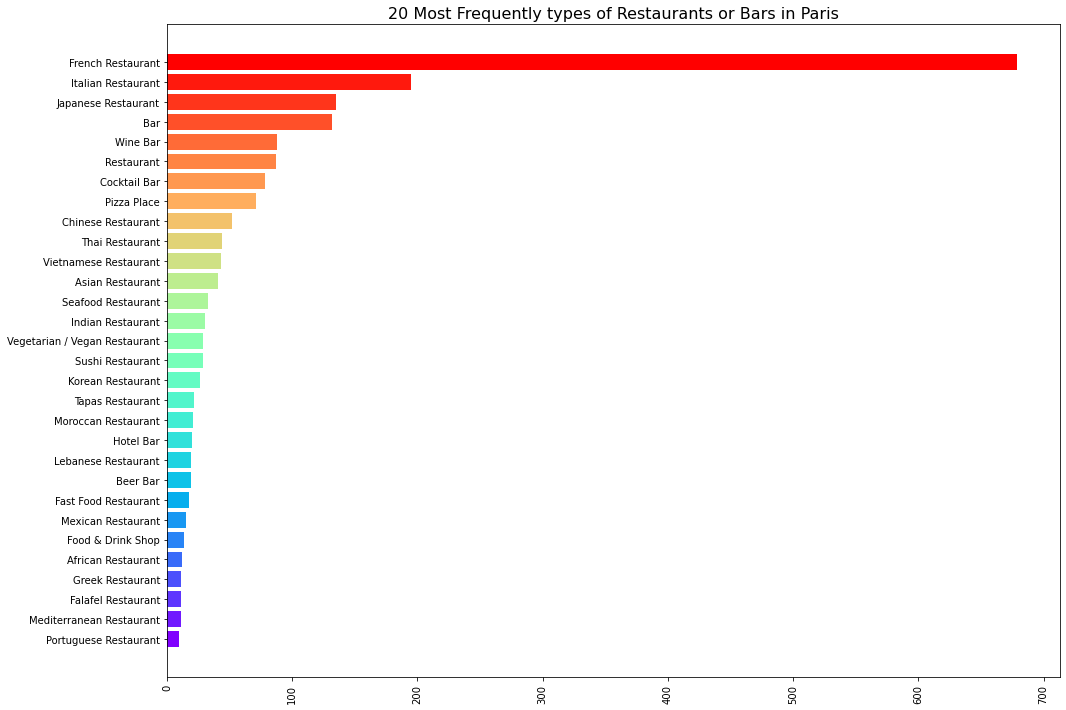

In [31]:
df_food_topn.sort_values('Frequency',inplace=True)
frequency = df_food_topn['Frequency']
venue = df_food_topn['Venue_Category']


colors = cm.rainbow(np.linspace(0, 1, len(frequency.index)))
plt.figure(figsize = (16, 12))
plt.xticks(rotation = 90)
plt.xlabel("", fontsize = 16)
plt.ylabel("", fontsize = 16)
plt.title("20 Most Frequently types of Restaurants or Bars in Paris", fontsize = 16)
plt.barh(venue, frequency.values, color = colors)

### Step 04 - Performing one-hot encoding to analyze neighbourhoods with the PANDA library

One-Hot Encoding is a technique which ensures that machine learning algorithms can process data. Namely, it converts categorical variables into the binary Boolean ones.

#### One Hot Encoding

In [32]:
df_encoded = pd.get_dummies(df_food[['Venue Category']], prefix="", prefix_sep="")
df_encoded

,Afghan Restaurant,African Restaurant,Alsatian Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Auvergne Restaurant,Bar,Basque Restaurant,...,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wine Bar
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2232,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2233,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2234,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2235,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
df_encoded= pd.concat([df_food['Neighbourhood'],df_encoded],axis=1)
df_encoded.head(10)

,Neighbourhood,Afghan Restaurant,African Restaurant,Alsatian Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Auvergne Restaurant,Bar,...,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wine Bar
1,Palais-Royal,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,Palais-Royal,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,Palais-Royal,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Palais-Royal,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,Palais-Royal,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,Palais-Royal,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,Palais-Royal,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,Palais-Royal,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,Palais-Royal,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,Palais-Royal,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
df_grouped = df_encoded.groupby('Neighbourhood').mean().reset_index()
df_grouped.head()

,Neighbourhood,Afghan Restaurant,African Restaurant,Alsatian Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Auvergne Restaurant,Bar,...,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wine Bar
0,Amérique,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
1,Archives,0.0,0.0,0.0,0.0,0.0,0.000000,0.02381,0.0,0.095238,...,0.071429,0.047619,0.0,0.0,0.0,0.0,0.023810,0.0,0.000000,0.023810
2,Arsenal,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.032258,...,0.064516,0.064516,0.0,0.0,0.0,0.0,0.064516,0.0,0.000000,0.032258
3,Arts-et-Métiers,0.0,0.0,0.0,0.0,0.0,0.018182,0.00000,0.0,0.054545,...,0.018182,0.018182,0.0,0.0,0.0,0.0,0.018182,0.0,0.054545,0.090909
4,Auteuil,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000


In [35]:
df_grouped.shape

(79, 103)

#### Return 10 Most Common Venues for each Neighbourhood

In [36]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [37]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
# create a new dataframe
df_venues_sorted = pd.DataFrame(columns=columns)
df_venues_sorted['Neighbourhood'] = df_grouped['Neighbourhood']

for ind in np.arange(df_grouped.shape[0]):
    df_venues_sorted.iloc[ind, 1:] = return_most_common_venues(df_grouped.iloc[ind, :], num_top_venues)

df_venues_sorted

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Amérique,French Restaurant,Health Food Store,Wine Bar,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Fondue Restaurant
1,Archives,French Restaurant,Italian Restaurant,Bar,Japanese Restaurant,Cocktail Bar,Tapas Restaurant,Falafel Restaurant,Thai Restaurant,Pizza Place,Cajun / Creole Restaurant
2,Arsenal,French Restaurant,Vegetarian / Vegan Restaurant,Cocktail Bar,Italian Restaurant,Thai Restaurant,Tapas Restaurant,Wine Bar,Southwestern French Restaurant,Bar,Brazilian Restaurant
3,Arts-et-Métiers,French Restaurant,Wine Bar,Cocktail Bar,Chinese Restaurant,Italian Restaurant,Restaurant,Bar,Vietnamese Restaurant,Japanese Restaurant,Moroccan Restaurant
4,Auteuil,French Restaurant,Wine Bar,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Fondue Restaurant,Food
...,...,...,...,...,...,...,...,...,...,...,...
74,Sorbonne,French Restaurant,Bar,Wine Bar,Italian Restaurant,Lebanese Restaurant,Seafood Restaurant,Asian Restaurant,Chinese Restaurant,Cocktail Bar,Ethiopian Restaurant
75,Ternes,French Restaurant,Italian Restaurant,Seafood Restaurant,Japanese Restaurant,Hotel Bar,Moroccan Restaurant,American Restaurant,Asian Restaurant,Breton Restaurant,Cocktail Bar
76,Val-de-Grâce,French Restaurant,Bar,Asian Restaurant,Wine Bar,Pizza Place,Chinese Restaurant,Mexican Restaurant,Lebanese Restaurant,Beer Bar,Korean Restaurant
77,Villette,Bar,French Restaurant,Food Truck,Italian Restaurant,Fast Food Restaurant,Asian Restaurant,Beer Bar,Seafood Restaurant,Japanese Restaurant,Middle Eastern Restaurant


### Step 05 - Clustering K-means with sklearn.cluster library

#### Showing the optimal k with the Elbow Method

In [38]:
df_k_clustering = df_grouped.drop('Neighbourhood', 1)

distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(df_k_clustering)
    distortions.append(kmeanModel.inertia_)

Text(0.5, 1.0, 'The Elbow Method showing the optimal k')

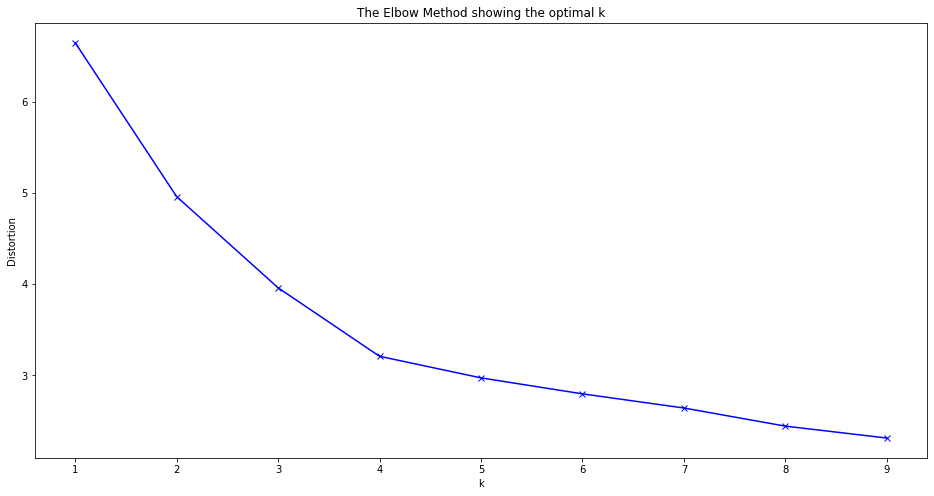

In [39]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')

#### K-means with the optimal k showing with the Elbow Method

In [40]:
from sklearn.cluster import KMeans

k_clusters = 4

#drop the Neighbourhood column to work with numerical values only
df_k_clustering = df_grouped.drop('Neighbourhood', 1)

KM = KMeans(n_clusters=k_clusters, random_state=0)

In [41]:
KM.fit(df_k_clustering)
KM

KMeans(n_clusters=4, random_state=0)

In [42]:
KM.labels_[0:10]

array([2, 3, 0, 3, 2, 0, 2, 3, 3, 3], dtype=int32)

#### Add the clusters label to the final dataframe

In [43]:
#adding the labels to the top10 df
df_venues_sorted.insert(0, 'Cluster Labels', KM.labels_)
df_venues_sorted

,Cluster Labels,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,2,Amérique,French Restaurant,Health Food Store,Wine Bar,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Fondue Restaurant
1,3,Archives,French Restaurant,Italian Restaurant,Bar,Japanese Restaurant,Cocktail Bar,Tapas Restaurant,Falafel Restaurant,Thai Restaurant,Pizza Place,Cajun / Creole Restaurant
2,0,Arsenal,French Restaurant,Vegetarian / Vegan Restaurant,Cocktail Bar,Italian Restaurant,Thai Restaurant,Tapas Restaurant,Wine Bar,Southwestern French Restaurant,Bar,Brazilian Restaurant
3,3,Arts-et-Métiers,French Restaurant,Wine Bar,Cocktail Bar,Chinese Restaurant,Italian Restaurant,Restaurant,Bar,Vietnamese Restaurant,Japanese Restaurant,Moroccan Restaurant
4,2,Auteuil,French Restaurant,Wine Bar,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Fondue Restaurant,Food
...,...,...,...,...,...,...,...,...,...,...,...,...
74,0,Sorbonne,French Restaurant,Bar,Wine Bar,Italian Restaurant,Lebanese Restaurant,Seafood Restaurant,Asian Restaurant,Chinese Restaurant,Cocktail Bar,Ethiopian Restaurant
75,0,Ternes,French Restaurant,Italian Restaurant,Seafood Restaurant,Japanese Restaurant,Hotel Bar,Moroccan Restaurant,American Restaurant,Asian Restaurant,Breton Restaurant,Cocktail Bar
76,3,Val-de-Grâce,French Restaurant,Bar,Asian Restaurant,Wine Bar,Pizza Place,Chinese Restaurant,Mexican Restaurant,Lebanese Restaurant,Beer Bar,Korean Restaurant
77,3,Villette,Bar,French Restaurant,Food Truck,Italian Restaurant,Fast Food Restaurant,Asian Restaurant,Beer Bar,Seafood Restaurant,Japanese Restaurant,Middle Eastern Restaurant


#### Join dataframe "df_venues_sorted" to dataframe "borough_neighbourhoodDF" to obtain the final dataframe "df_venues_final"

In [44]:
df_venues_final = df_venues_sorted.join(borough_neighbourhoodDF.set_index('Neighbourhood'), on='Neighbourhood')
df_venues_final

,Cluster Labels,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,...,BoroughNumber,Borough,Latitude,Longitude,BoroughPerimetre,NeighNumber,NeighLatitude,NeighLongitude,NeighGeoloc,NeighPerimetre
0,2,Amérique,French Restaurant,Health Food Store,Wine Bar,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,...,19,Buttes-Chaumont,48.887076,2.384821,11253.182479,75,48.881638,2.395440,"[48.8816381673, 2.39544016662]",6399.022082
1,3,Archives,French Restaurant,Italian Restaurant,Bar,Japanese Restaurant,Cocktail Bar,Tapas Restaurant,Falafel Restaurant,Thai Restaurant,...,3,Temple,48.862872,2.360001,4519.263648,11,48.859192,2.363205,"[48.8591924127, 2.36320505733]",2534.100042
2,0,Arsenal,French Restaurant,Vegetarian / Vegan Restaurant,Cocktail Bar,Italian Restaurant,Thai Restaurant,Tapas Restaurant,Wine Bar,Southwestern French Restaurant,...,4,Hôtel-de-Ville,48.854341,2.357630,5420.908434,15,48.851585,2.364768,"[48.851585175, 2.36476795387]",2878.559656
3,3,Arts-et-Métiers,French Restaurant,Wine Bar,Cocktail Bar,Chinese Restaurant,Italian Restaurant,Restaurant,Bar,Vietnamese Restaurant,...,3,Temple,48.862872,2.360001,4519.263648,9,48.866470,2.357083,"[48.8664702895, 2.35708313106]",2482.460453
4,2,Auteuil,French Restaurant,Wine Bar,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,...,16,Passy,48.860392,2.261971,17416.109657,61,48.850622,2.252277,"[48.8506223427, 2.25227690754]",12452.253931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,0,Sorbonne,French Restaurant,Bar,Wine Bar,Italian Restaurant,Lebanese Restaurant,Seafood Restaurant,Asian Restaurant,Chinese Restaurant,...,5,Panthéon,48.844443,2.350715,6239.195396,20,48.849045,2.345747,"[48.8490447659, 2.34574660019]",2892.944068
75,0,Ternes,French Restaurant,Italian Restaurant,Seafood Restaurant,Japanese Restaurant,Hotel Bar,Moroccan Restaurant,American Restaurant,Asian Restaurant,...,17,Batignolles-Monceau,48.887327,2.306777,10775.579516,65,48.881178,2.289964,"[48.8811775503, 2.28996373812]",5264.597082
76,3,Val-de-Grâce,French Restaurant,Bar,Asian Restaurant,Wine Bar,Pizza Place,Chinese Restaurant,Mexican Restaurant,Lebanese Restaurant,...,5,Panthéon,48.844443,2.350715,6239.195396,19,48.841684,2.343861,"[48.841684288, 2.34386092632]",3485.831358
77,3,Villette,Bar,French Restaurant,Food Truck,Italian Restaurant,Fast Food Restaurant,Asian Restaurant,Beer Bar,Seafood Restaurant,...,19,Buttes-Chaumont,48.887076,2.384821,11253.182479,73,48.887661,2.374468,"[48.8876610888, 2.37446821213]",5191.018830


In [45]:
#check for null values
df_venues_final[df_venues_final['Cluster Labels'].isnull()]

,Cluster Labels,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,...,BoroughNumber,Borough,Latitude,Longitude,BoroughPerimetre,NeighNumber,NeighLatitude,NeighLongitude,NeighGeoloc,NeighPerimetre


### Step 06 - Cluster Analysis

#### Cluster 1 (0) - French and Italian Restaurants

In [89]:
cluster = 0
cluster_1 = df_venues_final.loc[df_venues_final['Cluster Labels'] == cluster, df_venues_final.columns[[1] + list(range(2, df_venues_final.shape[1]))]]

In [90]:
cluster_1_1stMostCommonVenue = cluster_1['1st Most Common Venue'].value_counts()[0:topn].to_frame(name='frequency')
cluster_1_2ndMostCommonVenue = cluster_1['2nd Most Common Venue'].value_counts()[0:topn].to_frame(name='frequency')
cluster_1_3rdMostCommonVenue = cluster_1['3rd Most Common Venue'].value_counts()[0:topn].to_frame(name='frequency')
print(cluster_1_1stMostCommonVenue);print(cluster_1_2ndMostCommonVenue);print(cluster_1_3rdMostCommonVenue)

                   frequency
French Restaurant         36
                               frequency
Italian Restaurant                    17
Bar                                    4
Japanese Restaurant                    3
Wine Bar                               2
Pizza Place                            2
Vegetarian / Vegan Restaurant          2
Chinese Restaurant                     1
Food Truck                             1
Portuguese Restaurant                  1
Greek Restaurant                       1
Vietnamese Restaurant                  1
Corsican Restaurant                    1
                               frequency
Japanese Restaurant                    6
Italian Restaurant                     5
Wine Bar                               4
Pizza Place                            4
Bar                                    3
Vietnamese Restaurant                  2
Thai Restaurant                        2
Hotel Bar                              2
Restaurant                             2

In [91]:
cluster_1

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,...,BoroughNumber,Borough,Latitude,Longitude,BoroughPerimetre,NeighNumber,NeighLatitude,NeighLongitude,NeighGeoloc,NeighPerimetre
2,Arsenal,French Restaurant,Vegetarian / Vegan Restaurant,Cocktail Bar,Italian Restaurant,Thai Restaurant,Tapas Restaurant,Wine Bar,Southwestern French Restaurant,Bar,...,4,Hôtel-de-Ville,48.854341,2.357630,5420.908434,15,48.851585,2.364768,"[48.851585175, 2.36476795387]",2878.559656
5,Batignolles,French Restaurant,Italian Restaurant,Bar,Restaurant,Pizza Place,Japanese Restaurant,Turkish Restaurant,Chinese Restaurant,Cocktail Bar,...,17,Batignolles-Monceau,48.887327,2.306777,10775.579516,67,48.888482,2.313856,"[48.8884815139, 2.31385616901]",5832.690026
10,Chaillot,French Restaurant,Italian Restaurant,Japanese Restaurant,Chinese Restaurant,Seafood Restaurant,Bar,Cambodian Restaurant,Cantonese Restaurant,Food & Drink Shop,...,16,Passy,48.860392,2.261971,17416.109657,64,48.868434,2.291679,"[48.8684336145, 2.29167904274]",5207.046446
11,Champs-Elysées,French Restaurant,Italian Restaurant,Japanese Restaurant,Peruvian Restaurant,Hotel Bar,Thai Restaurant,Cocktail Bar,Seafood Restaurant,Alsatian Restaurant,...,8,Élysée,48.872721,2.312554,7880.533268,29,48.867074,2.308652,"[48.8670744922, 2.30865168468]",5480.652870
13,Chaussée-d'Antin,French Restaurant,Italian Restaurant,Vietnamese Restaurant,Chinese Restaurant,Restaurant,Vegetarian / Vegan Restaurant,Indian Restaurant,Seafood Restaurant,Fondue Restaurant,...,9,Opéra,48.877164,2.337458,6471.588290,34,48.873547,2.332269,"[48.8735473802, 2.33226886887]",3133.580092
15,Combat,French Restaurant,Italian Restaurant,Restaurant,Wine Bar,Thai Restaurant,Bar,Latin American Restaurant,Moroccan Restaurant,Japanese Restaurant,...,19,Buttes-Chaumont,48.887076,2.384821,11253.182479,76,48.878639,2.380127,"[48.8786390757, 2.38012728183]",4435.273252
20,Europe,French Restaurant,Pizza Place,Thai Restaurant,Wine Bar,Sushi Restaurant,Italian Restaurant,Gluten-free Restaurant,Korean Restaurant,Lebanese Restaurant,...,8,Élysée,48.872721,2.312554,7880.533268,32,48.878148,2.317175,"[48.8781476759, 2.3171746113]",4803.242769
21,Faubourg-Montmartre,French Restaurant,Italian Restaurant,Vegetarian / Vegan Restaurant,Chinese Restaurant,Restaurant,Cocktail Bar,Doner Restaurant,Pizza Place,Japanese Restaurant,...,9,Opéra,48.877164,2.337458,6471.588290,35,48.873935,2.343253,"[48.8739346918, 2.34325257947]",2786.541926
22,Faubourg-du-Roule,French Restaurant,Italian Restaurant,Japanese Restaurant,Asian Restaurant,Hotel Bar,Scandinavian Restaurant,Seafood Restaurant,Fast Food Restaurant,Food,...,8,Élysée,48.872721,2.312554,7880.533268,30,48.874136,2.304119,"[48.8741355756, 2.30411880972]",3773.673073
27,Grandes-Carrières,French Restaurant,Bar,Restaurant,Italian Restaurant,Pizza Place,Thai Restaurant,Wine Bar,Greek Restaurant,Indian Restaurant,...,18,Buttes-Montmartre,48.892569,2.348161,9916.464176,69,48.892578,2.334363,"[48.8925777711, 2.33436308991]",6398.474434


#### Cluster 2 (1) - Pizza Place and International Cuisine

In [86]:
cluster = 1
cluster_2 = df_venues_final.loc[df_venues_final['Cluster Labels'] == cluster, df_venues_final.columns[[1] + list(range(2, df_venues_final.shape[1]))]]

In [87]:
cluster_2_1stMostCommonVenue = cluster_2['1st Most Common Venue'].value_counts()[0:topn].to_frame(name='frequency')
cluster_2_2ndMostCommonVenue = cluster_2['2nd Most Common Venue'].value_counts()[0:topn].to_frame(name='frequency')
cluster_2_3rdMostCommonVenue = cluster_2['3rd Most Common Venue'].value_counts()[0:topn].to_frame(name='frequency')
print(cluster_2_1stMostCommonVenue);print(cluster_2_2ndMostCommonVenue);print(cluster_2_3rdMostCommonVenue)

             frequency
Pizza Place          1
          frequency
Wine Bar          1
            frequency
Food Truck          1


In [88]:
cluster_2

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,...,BoroughNumber,Borough,Latitude,Longitude,BoroughPerimetre,NeighNumber,NeighLatitude,NeighLongitude,NeighGeoloc,NeighPerimetre
53,Porte-Dauphine,Pizza Place,Wine Bar,Food Truck,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,...,16,Passy,48.860392,2.261971,17416.109657,63,48.871766,2.271918,"[48.8717656343, 2.27191774047]",7447.041546


#### Cluster 3 (2) - French Restaurants and Wine Bars

In [82]:
cluster = 2
cluster_3 = df_venues_final.loc[df_venues_final['Cluster Labels'] == cluster, df_venues_final.columns[[1] + list(range(2, df_venues_final.shape[1]))]]

In [80]:
cluster_3_1stMostCommonVenue = cluster_3['1st Most Common Venue'].value_counts()[0:topn].to_frame(name='frequency')
cluster_3_2ndMostCommonVenue = cluster_3['2nd Most Common Venue'].value_counts()[0:topn].to_frame(name='frequency')
cluster_3_3rdMostCommonVenue = cluster_3['3rd Most Common Venue'].value_counts()[0:topn].to_frame(name='frequency')
print(cluster_3_1stMostCommonVenue);print(cluster_3_2ndMostCommonVenue);print(cluster_3_3rdMostCommonVenue)

                   frequency
French Restaurant          6
                    frequency
Wine Bar                    2
Health Food Store           1
Italian Restaurant          1
Snack Place                 1
Asian Restaurant            1
                             frequency
Wine Bar                             3
Eastern European Restaurant          2
Japanese Restaurant                  1


In [83]:
cluster_3

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,...,BoroughNumber,Borough,Latitude,Longitude,BoroughPerimetre,NeighNumber,NeighLatitude,NeighLongitude,NeighGeoloc,NeighPerimetre
0,Amérique,French Restaurant,Health Food Store,Wine Bar,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,...,19,Buttes-Chaumont,48.887076,2.384821,11253.182479,75,48.881638,2.395440,"[48.8816381673, 2.39544016662]",6399.022082
4,Auteuil,French Restaurant,Wine Bar,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Fondue Restaurant,...,16,Passy,48.860392,2.261971,17416.109657,61,48.850622,2.252277,"[48.8506223427, 2.25227690754]",12452.253931
6,Bel-Air,French Restaurant,Wine Bar,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Fondue Restaurant,...,12,Reuilly,48.834974,2.421325,24089.666298,45,48.837996,2.433178,"[48.8379956461, 2.43317844196]",18427.822238
17,Ecole-Militaire,French Restaurant,Asian Restaurant,Wine Bar,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,...,7,Palais-Bourbon,48.856174,2.312188,8099.424883,27,48.850359,2.311031,"[48.8503592615, 2.31103093627]",3887.703157
32,Invalides,French Restaurant,Italian Restaurant,Japanese Restaurant,Cocktail Bar,Restaurant,Vegetarian / Vegan Restaurant,Food,Doner Restaurant,Eastern European Restaurant,...,7,Palais-Bourbon,48.856174,2.312188,8099.424883,26,48.858515,2.316445,"[48.8585149661, 2.31644474034]",4434.656489
41,Muette,French Restaurant,Snack Place,Wine Bar,Food & Drink Shop,Doner Restaurant,Eastern European Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,...,16,Passy,48.860392,2.261971,17416.109657,62,48.863275,2.259936,"[48.8632745438, 2.2599358317]",11962.438594


#### Cluster 4 (3) - French Restaurants

In [84]:
cluster = 3
cluster_4 = df_venues_final.loc[df_venues_final['Cluster Labels'] == cluster, df_venues_final.columns[[1] + list(range(2, df_venues_final.shape[1]))]]

In [81]:
cluster_4_1stMostCommonVenue = cluster_4['1st Most Common Venue'].value_counts()[0:topn].to_frame(name='frequency')
cluster_4_2ndMostCommonVenue = cluster_4['2nd Most Common Venue'].value_counts()[0:topn].to_frame(name='frequency')
cluster_4_3rdMostCommonVenue = cluster_4['3rd Most Common Venue'].value_counts()[0:topn].to_frame(name='frequency')
print(cluster_4_1stMostCommonVenue);print(cluster_4_2ndMostCommonVenue);print(cluster_4_3rdMostCommonVenue)

                     frequency
French Restaurant           23
Bar                          5
Japanese Restaurant          3
Indian Restaurant            2
Cocktail Bar                 2
Italian Restaurant           1
                     frequency
French Restaurant            8
Bar                          7
Japanese Restaurant          7
Wine Bar                     3
Italian Restaurant           3
Restaurant                   2
Asian Restaurant             2
Chinese Restaurant           1
Cocktail Bar                 1
Sushi Restaurant             1
Thai Restaurant              1
                               frequency
Italian Restaurant                     7
Wine Bar                               7
Japanese Restaurant                    5
Cocktail Bar                           4
French Restaurant                      3
Chinese Restaurant                     2
Restaurant                             2
Food Truck                             1
Portuguese Restaurant                  1
V

In [85]:
cluster_4

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,...,BoroughNumber,Borough,Latitude,Longitude,BoroughPerimetre,NeighNumber,NeighLatitude,NeighLongitude,NeighGeoloc,NeighPerimetre
1,Archives,French Restaurant,Italian Restaurant,Bar,Japanese Restaurant,Cocktail Bar,Tapas Restaurant,Falafel Restaurant,Thai Restaurant,Pizza Place,...,3,Temple,48.862872,2.360001,4519.263648,11,48.859192,2.363205,"[48.8591924127, 2.36320505733]",2534.100042
3,Arts-et-Métiers,French Restaurant,Wine Bar,Cocktail Bar,Chinese Restaurant,Italian Restaurant,Restaurant,Bar,Vietnamese Restaurant,Japanese Restaurant,...,3,Temple,48.862872,2.360001,4519.263648,9,48.866470,2.357083,"[48.8664702895, 2.35708313106]",2482.460453
7,Belleville,Bar,French Restaurant,Japanese Restaurant,Italian Restaurant,Pizza Place,African Restaurant,Chinese Restaurant,Cocktail Bar,Indian Restaurant,...,20,Ménilmontant,48.863461,2.401188,10704.940486,77,48.871531,2.387549,"[48.8715312006, 2.38754923985]",3738.454432
8,Bercy,French Restaurant,Italian Restaurant,Japanese Restaurant,Restaurant,Bar,Beer Bar,Cambodian Restaurant,Chinese Restaurant,Doner Restaurant,...,12,Reuilly,48.834974,2.421325,24089.666298,47,48.835209,2.386210,"[48.8352090499, 2.38621008421]",6155.005036
9,Bonne-Nouvelle,Cocktail Bar,French Restaurant,Wine Bar,Japanese Restaurant,Restaurant,Italian Restaurant,Chinese Restaurant,Bar,Thai Restaurant,...,2,Bourse,48.868279,2.342803,4554.104360,8,48.867150,2.350080,"[48.8671501183, 2.35008019041]",2233.976030
12,Charonne,Bar,Japanese Restaurant,Portuguese Restaurant,Pizza Place,Fast Food Restaurant,French Restaurant,Brazilian Restaurant,Indian Restaurant,Hawaiian Restaurant,...,20,Ménilmontant,48.863461,2.401188,10704.940486,80,48.854760,2.407430,"[48.854760283, 2.40743032824]",6167.338265
14,Clignancourt,French Restaurant,Bar,Italian Restaurant,Pizza Place,Restaurant,Wine Bar,Seafood Restaurant,Arepa Restaurant,Asian Restaurant,...,18,Buttes-Montmartre,48.892569,2.348161,9916.464176,70,48.891668,2.345979,"[48.8916675911, 2.34597875459]",6005.520389
16,Croulebarbe,French Restaurant,Sushi Restaurant,Italian Restaurant,Bar,Ramen Restaurant,Restaurant,Indian Restaurant,Cocktail Bar,Ethiopian Restaurant,...,13,Gobelins,48.828388,2.362272,11546.546526,52,48.833734,2.347673,"[48.8337336761, 2.34767304607]",3289.230480
18,Enfants-Rouges,French Restaurant,Wine Bar,Japanese Restaurant,Italian Restaurant,Vietnamese Restaurant,Cocktail Bar,Bar,Korean Restaurant,Restaurant,...,3,Temple,48.862872,2.360001,4519.263648,10,48.863887,2.363123,"[48.863887392, 2.36312330099]",2139.625388
19,Epinettes,French Restaurant,Restaurant,Japanese Restaurant,Turkish Restaurant,Pizza Place,Bar,Ethiopian Restaurant,Sushi Restaurant,Hotel Bar,...,17,Batignolles-Monceau,48.887327,2.306777,10775.579516,68,48.894943,2.321119,"[48.8949426538, 2.32111874371]",5171.706451


### Step 07 - Creation of a clusters map with the folium library

#### Retrieve the geographical coordinates of Paris

In [60]:
address = 'Paris'

geolocator = Nominatim(user_agent="Paris_Explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(f'The geograpical coordinates of Paris are {latitude}, {longitude}.')

The geograpical coordinates of Paris are 48.8566969, 2.3514616.


#### Creation of the map with the Neighbourhoods of Paris

In [61]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(k_clusters)
ys = [i + x + (i*x)**2 for i in range(k_clusters)]
#colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
#colors_array = ['green','blue','red','grey','yellow']
colors_array = [
    'red',
    'blue',
    'orange',
    'green',
    'beige',
    'purple',
    'pink',
    'darkred',
    'darkgreen',
    'lightgreen',
    'darkblue',
    'lightblue',
    'gray',
    'cadetblue',
    'lightgray',
    'black'
]
#rainbow = [colors.rgb2hex(i) for i in colors_array]
rainbow = colors_array

# add markers to the map
markers_colors = []
legend = []

for geoloc, poi, cluster in zip(df_venues_final['NeighGeoloc'], df_venues_final['Neighbourhood'], df_venues_final['Cluster Labels']):
    label = folium.Popup('Cluster ' + str(int(cluster) + 1) + '\n' + str(poi) , parse_html=True)
    
    color=rainbow[cluster - 1]
    libelCluster = "Cluster " + str(cluster)
    legend.append(libelCluster)
    legend.append(color)
    
    folium.CircleMarker(
        geoloc,
        radius=5,
        popup=label,
        color=rainbow[cluster - 1],
        fill=True,
        fill_color=rainbow[cluster - 1],
        fill_opacity=0.9).add_to(map_clusters)        
#map_clusters
#NeighGeoloc
#legend

#### Adding a legend to the map of Paris neighborhoods

In [92]:

from branca.element import Template, MacroElement

template = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>jQuery UI Draggable - Default functionality</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
  
  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
});

  </script>
</head>
<body>

 
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:14px; right: 20px; bottom: 20px;'>
     
<div class='legend-title'>Paris Neighborhoods Clustering</div>
<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:black;opacity:0.7;'></span>Cluster 1 - French and Italian Restaurants</li>
    <li><span style='background:red;opacity:0.7;'></span>Cluster 2 - Pizza Place and International Cuisine</li>
    <li><span style='background:blue;opacity:0.7;'></span>Cluster 3 - French Restaurants and Wine Bars</li>
    <li><span style='background:orange;opacity:0.7;'></span>Cluster 4 - French Restaurants</li>
  </ul>
</div>
</div>
 
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 16px;
    width: 30px;
    margin-right: 5px;
    margin-left: 0;
    border: 1px solid #999;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""

macro = MacroElement()
macro._template = Template(template)

map_clusters.get_root().add_child(macro)

map_clusters

## Discussion

## Conclusion